In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from datetime import date, datetime, timedelta
from plotly import __version__


import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot
import seaborn as sns

In [46]:
CSSE_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
cases = pd.read_csv(CSSE_url, dtype = {'FIPS' : np.str_})
cases['FIPS'] = cases['FIPS'].str[:-2].str.zfill(5)
cases['FIPS'] = cases['FIPS'].str.zfill(5)

cases = cases.dropna()
cases = cases.set_index('FIPS')
cases = cases[cases['Admin2'] != 'Unassigned']

In [47]:
def perdelta(start, end, delta):
    curr = start
    while curr < end:
        yield curr
        curr += delta
weekly_state = []
for i in perdelta(date(2020, 6, 21), date(2021, 9, 5), timedelta(days=7)):
    t = i.strftime('%Y-%m-%d')
    weekly_state.append(t)

### Get weekly cases for US

In [48]:
daily_cases = cases.iloc[:, 19:] - cases.iloc[:, 19:].shift(axis = 1)
daily_cases = daily_cases.dropna(axis = 1)
date_column = pd.to_datetime(daily_cases.columns).strftime('%Y-%m-%d')
daily_cases.columns = cases_date = date_column
daily_cases_state = daily_cases.groupby(daily_cases.index.str[:2]).sum().iloc[:, 1:]
daily_cases_state = daily_cases_state.iloc[:, 140:581]
weekly_cases_state = daily_cases_state.groupby((np.arange(len(daily_cases_state.columns)) // 7) + 1, axis=1).sum().add_prefix('s')

In [49]:
weekly_cases_state.columns = weekly_state

In [50]:
weekly_cases_state = weekly_cases_state.unstack().reset_index().rename(columns = {'level_0' : 'Date', 0 : 'Weekly reported Cases'})

In [51]:
weekly_cases_state = weekly_cases_state.groupby(['Date']).sum().reset_index()

### Get best performance model

In [52]:
cases_period1 = pd.read_csv('/Users/hongru/Projects/Covid_Forecast/final_result/cases/model2_period1.csv',
                           dtype = {'FIPS' : np.str_}).drop(columns = ['Unnamed: 0'])

In [53]:
cases_period1 = cases_period1[(cases_period1['main_date_range'] == 45)&(cases_period1['features_date_range'] == 75)].reset_index().dropna()

In [54]:
cases_period2 = pd.read_csv('/Users/hongru/Projects/Covid_Forecast/final_result/cases/model1_period2.csv',
                           dtype = {'FIPS' : np.str_}).drop(columns = ['Unnamed: 0'])

In [55]:
cases_period2 = cases_period2[(cases_period2['main_date_range'] == 40)&(cases_period2['features_date_range'] == 40)].reset_index().dropna()

In [56]:
cases_all = cases_period1.append(cases_period2)

In [58]:
cases_PAE_LSTM = cases_all[['FIPS',  'Week','LSTM_prediction', 'PAE_LSTM', 'Prediction_date']]

In [59]:
cases_PAE_LSTM['Model'] = 'Multi-stage LSTM'

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [60]:
cases_PAE_LSTM = cases_PAE_LSTM.groupby(['FIPS', 'Week', 'Prediction_date', 'Model']).mean().dropna().reset_index()

In [61]:
cases_PAE_LSTM = cases_PAE_LSTM.rename(columns = {'LSTM_prediction' : 'Prediction'})

In [62]:
cases_PAE_CDC = cases_all[['FIPS', 'Week', 'Ensemble_prediction', 'PAE_CDC', 'Prediction_date']]

In [63]:
cases_PAE_CDC['Model'] = 'CDC Ensemble'

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [64]:
cases_PAE_CDC = cases_PAE_CDC.rename(columns = {'PAE_CDC' : 'PAE'})

In [65]:
cases_PAE_CDC = cases_PAE_CDC.groupby(['FIPS', 'Week', 'Prediction_date', 'Model']).mean().dropna().reset_index()

In [66]:
cases_PAE_CDC = cases_PAE_CDC.rename(columns = {'Ensemble_prediction' : 'Prediction'})

In [67]:
cases_PAE_all = cases_PAE_LSTM.rename(columns = {'PAE_LSTM' : 'PAE'}).append(cases_PAE_CDC)

In [68]:
cases_PAE_all['Prediction'] = np.round(cases_PAE_all['Prediction'])

In [371]:
cases_PAE_all.to_csv('/Users/hongru/Projects/Covid_Forecast/final_result/cases_PAE_all.csv',
                    index = False)

In [69]:
cases_PAE_all['Date'] = cases_PAE_all['Prediction_date']


In [70]:
cases_PAE_week1 = cases_PAE_all[cases_PAE_all['Week'] == 'Week1'].reset_index().drop(columns = ['index'])

In [71]:
cases_PAE_week1['Date'] = (pd.to_datetime(cases_PAE_week1['Date']) + timedelta(1)).dt.strftime('%Y-%m-%d')

In [72]:
cases_PAE_week2 = cases_PAE_all[cases_PAE_all['Week'] == 'Week2'].reset_index().drop(columns = ['index'])

In [73]:
cases_PAE_week2['Date'] = (pd.to_datetime(cases_PAE_week2['Date']) + timedelta(8)).dt.strftime('%Y-%m-%d')

In [74]:
cases_PAE_week3 = cases_PAE_all[cases_PAE_all['Week'] == 'Week3'].reset_index().drop(columns = ['index'])

In [75]:
cases_PAE_week3['Date'] = (pd.to_datetime(cases_PAE_week3['Date']) + timedelta(15)).dt.strftime('%Y-%m-%d')

In [76]:
cases_PAE_week4 = cases_PAE_all[cases_PAE_all['Week'] == 'Week4'].reset_index().drop(columns = ['index'])
cases_PAE_week4['Date'] = (pd.to_datetime(cases_PAE_week4['Date']) + timedelta(22)).dt.strftime('%Y-%m-%d')

In [77]:
PAE_all = cases_PAE_week1.append(cases_PAE_week2).append(cases_PAE_week3).append(cases_PAE_week4)

In [389]:
PAE_all.to_csv('/Users/hongru/Projects/Covid_Forecast/final_result/cases_PAE_all.csv',
              index = False)

In [79]:
cases_PAE_week1['PAE'] = cases_PAE_week1['PAE']*100

In [80]:
cases_PAE_week2['PAE'] = cases_PAE_week2['PAE']*100
cases_PAE_week3['PAE'] = cases_PAE_week3['PAE']*100
cases_PAE_week4['PAE'] = cases_PAE_week4['PAE']*100

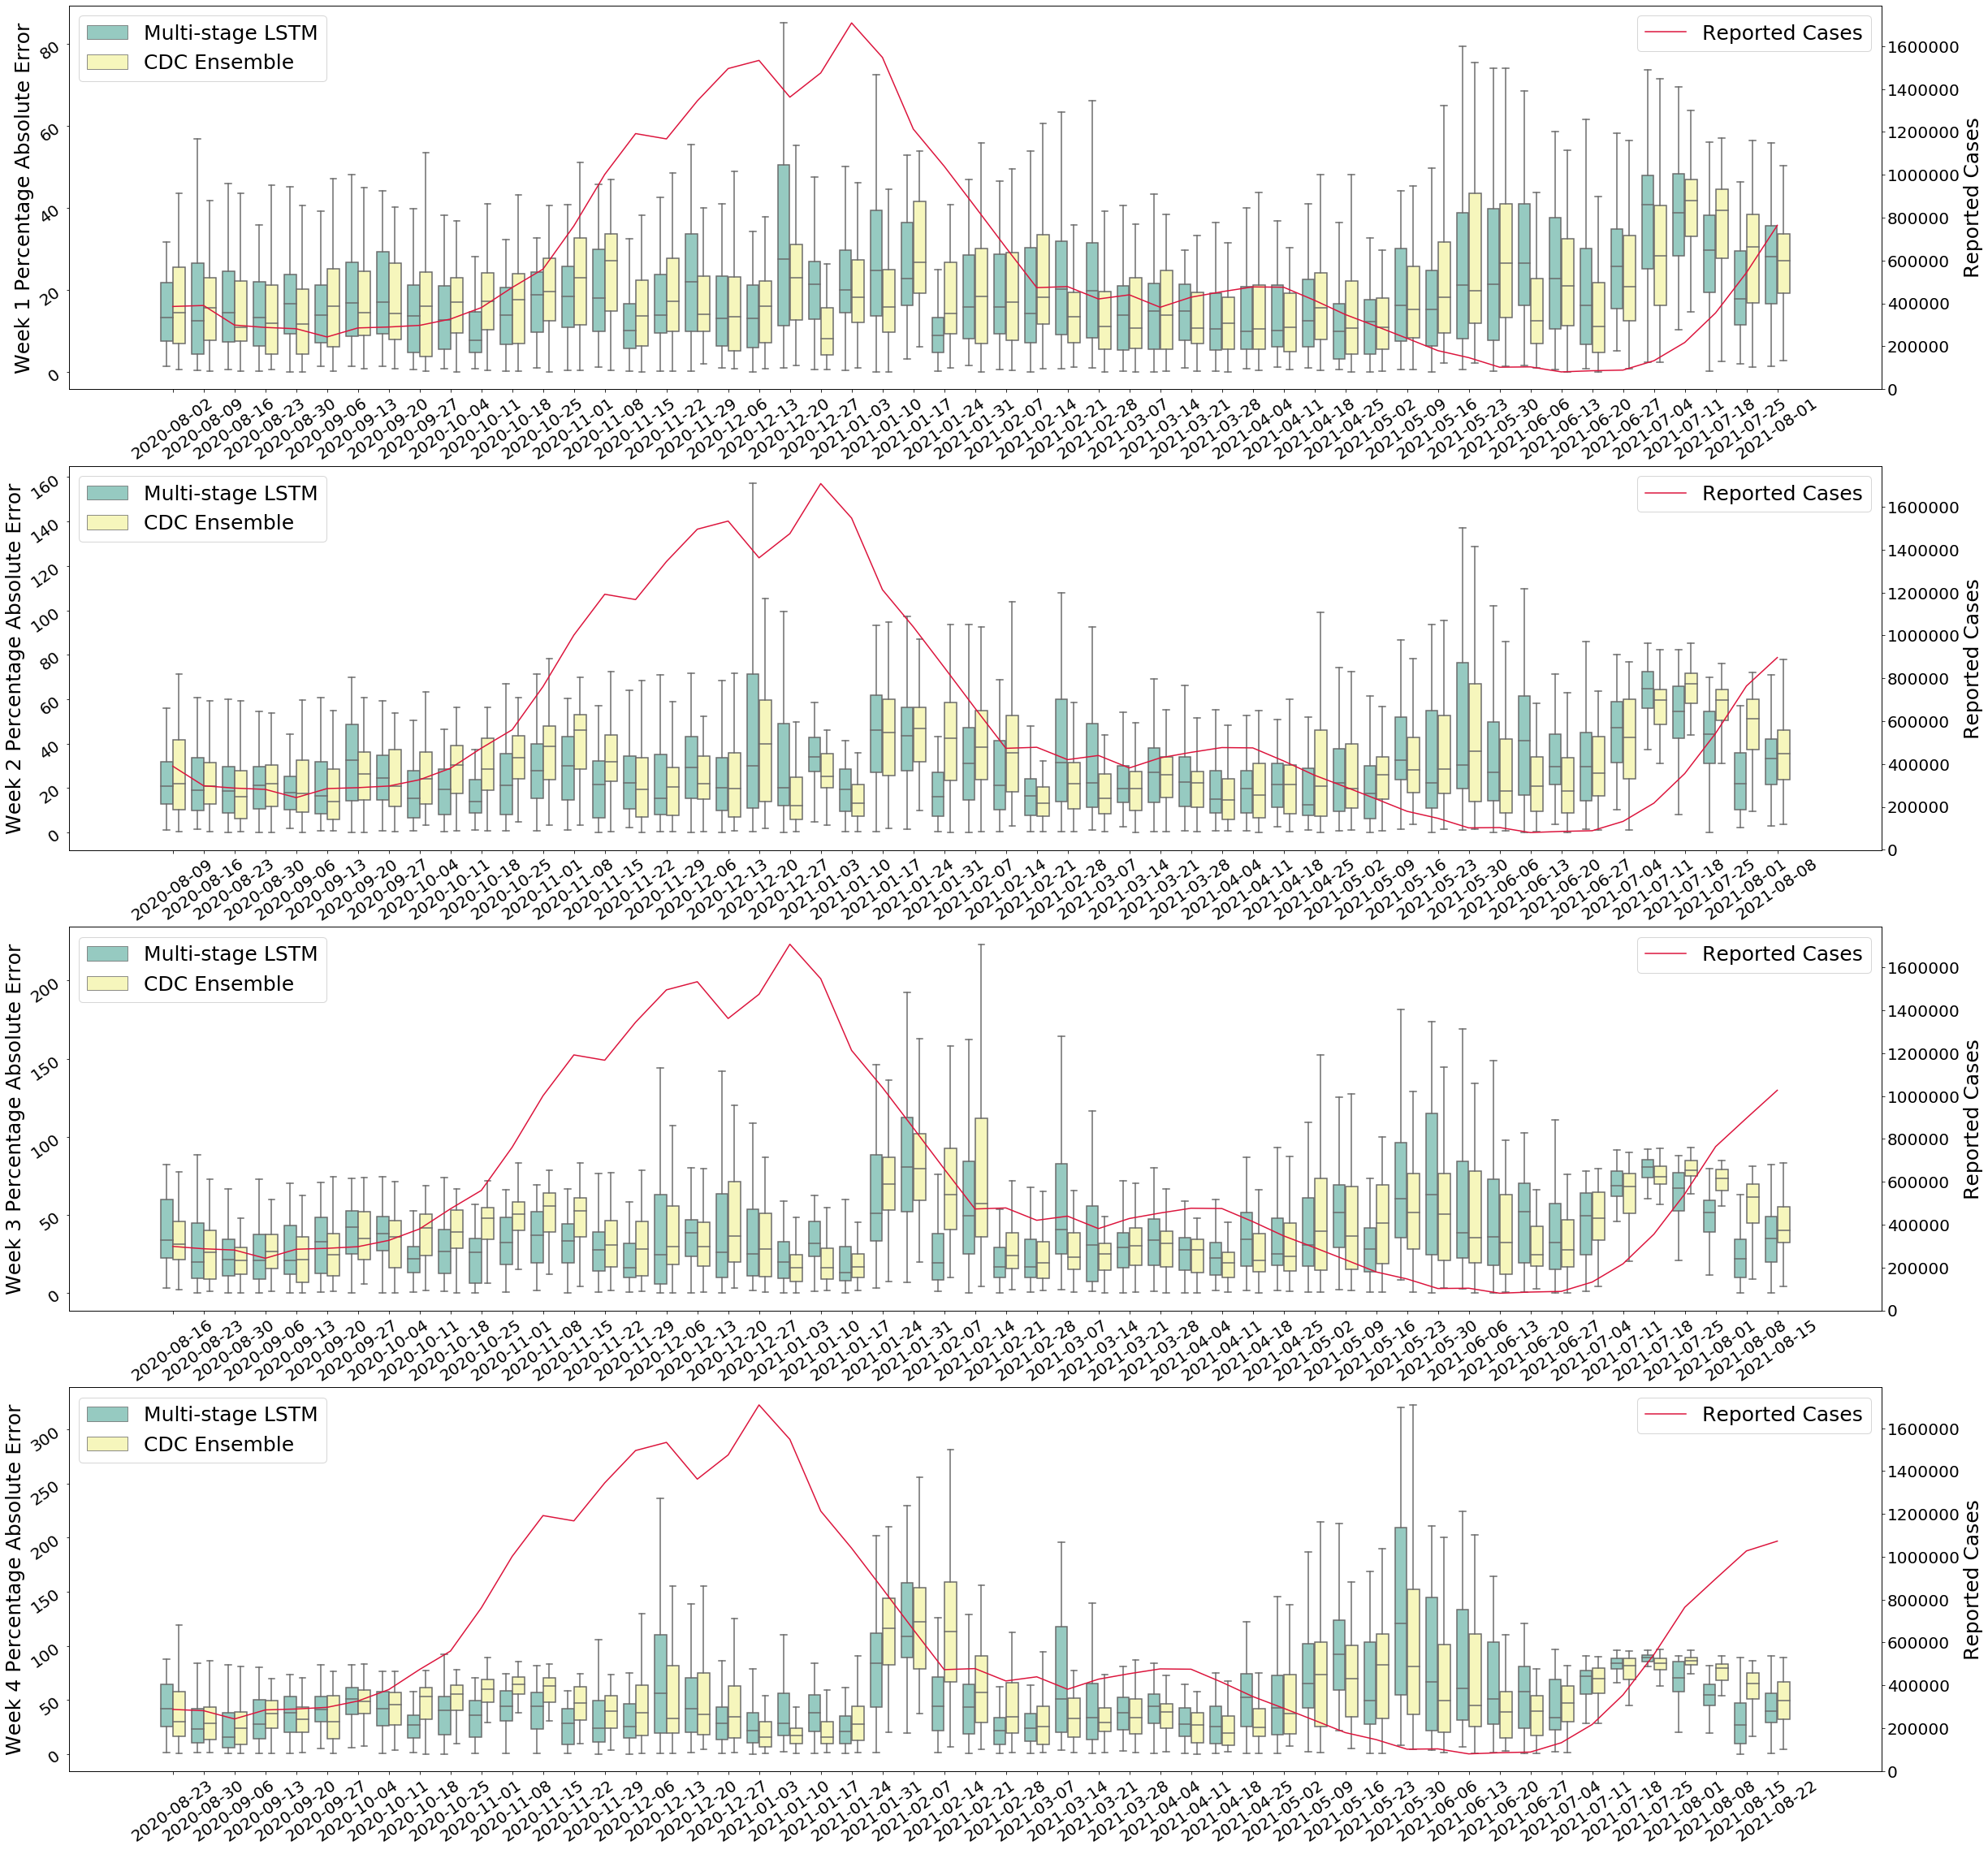

In [81]:
fig, axs = plt.subplots(4, figsize=(40,40))
# fig.tight_layout()
# fig.subplots_adjust(hspace=.5)
# f = plt.figure(figsize=(25,8))
#ax[0,0]

sns.boxplot(ax = axs[0], x="Date", y="PAE", hue="Model",
                 data=cases_PAE_week1, palette="Set3", showfliers = False)
axs[0].tick_params(labelrotation=35)
axs[0].legend(loc="upper left",prop={'size': 25})
axs[0].set_xlabel('')
axs[0].set_ylabel('Week 1 Percentage Absolute Error', fontsize = 25)
axs[0].tick_params(labelsize=20)

ax0 = axs[0].twinx()
ax0.plot(weekly_cases_state[weekly_cases_state['Date'].isin(cases_PAE_week1['Date'])]['Date'],
         weekly_cases_state[weekly_cases_state['Date'].isin(cases_PAE_week1['Date'])]['Weekly reported Cases'], 
         label = 'Reported Cases', color = 'crimson')
ax0.legend(loc="upper right", prop={'size': 25})
ax0.set_ylabel('Reported Cases', fontsize = 25)
ax0.tick_params(labelsize=20)


sns.boxplot(ax = axs[1], x="Date", y="PAE", hue="Model",
                 data=cases_PAE_week2, palette="Set3", showfliers = False)
axs[1].tick_params(labelrotation=35)
axs[1].legend(loc="upper left",prop={'size': 25})
axs[1].set_xlabel('')
axs[1].set_ylabel('Week 2 Percentage Absolute Error', fontsize = 25)
axs[1].tick_params(labelsize=20)

ax1 = axs[1].twinx()
ax1.plot(weekly_cases_state[weekly_cases_state['Date'].isin(cases_PAE_week2['Date'])]['Date'],
         weekly_cases_state[weekly_cases_state['Date'].isin(cases_PAE_week2['Date'])]['Weekly reported Cases'], 
         label = 'Reported Cases', color = 'crimson')
ax1.legend(loc="upper right", prop={'size': 25})
ax1.set_ylabel('Reported Cases', fontsize = 25)
ax1.tick_params(labelsize=20)


sns.boxplot(ax = axs[2], x="Date", y="PAE", hue="Model",
                 data=cases_PAE_week3, palette="Set3", showfliers = False)
axs[2].tick_params(labelrotation=35)
axs[2].legend(loc="upper left",prop={'size': 25})
axs[2].set_xlabel('')
axs[2].set_ylabel('Week 3 Percentage Absolute Error', fontsize = 25)
axs[2].tick_params(labelsize=20)

ax2 = axs[2].twinx()
ax2.plot(weekly_cases_state[weekly_cases_state['Date'].isin(cases_PAE_week3['Date'])]['Date'],
         weekly_cases_state[weekly_cases_state['Date'].isin(cases_PAE_week3['Date'])]['Weekly reported Cases'], 
         label = 'Reported Cases', color = 'crimson')
ax2.legend(loc="upper right", prop={'size': 25})
ax2.set_ylabel('Reported Cases', fontsize = 25)
ax2.tick_params(labelsize=20)

sns.boxplot(ax = axs[3], x="Date", y="PAE", hue="Model",
                 data=cases_PAE_week4, palette="Set3", showfliers = False)
axs[3].tick_params(labelrotation=35)
axs[3].legend(loc="upper left",prop={'size': 25})
axs[3].set_xlabel('')
axs[3].set_ylabel('Week 4 Percentage Absolute Error', fontsize = 25)
axs[3].tick_params(labelsize=20)

ax3 = axs[3].twinx()
ax3.plot(weekly_cases_state[weekly_cases_state['Date'].isin(cases_PAE_week4['Date'])]['Date'],
         weekly_cases_state[weekly_cases_state['Date'].isin(cases_PAE_week4['Date'])]['Weekly reported Cases'], 
         label = 'Reported Cases', color = 'crimson')
ax3.legend(loc="upper right", prop={'size': 25})
ax3.set_ylabel('Reported Cases', fontsize = 25)
ax3.tick_params(labelsize=20)

In [82]:
fig.savefig('/Users/hongru/Projects/deep_learning_paper/figures/overall_performance.png',
           dpi = 300, bbox_inches='tight')